In [1]:
import time
start_notebook_time = time.time()

In [2]:
import sklearn.linear_model
from sklearn.datasets import fetch_openml
import sys
import numpy as np

In [3]:
mnist = fetch_openml('mnist_784', version=1, parser='auto')

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
y = y.apply(lambda x : int(x))

In [6]:
X, y = X.to_numpy(), y.to_numpy()

In [7]:
X = np.concatenate((np.ones(shape=(X.shape[0],))[:, np.newaxis], X), axis=1)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
def accuracy(predictions, y_test):
    return np.sum(predictions == y_test) / len(y_test)

def binary_softmax(s):
    return 1 / (1 + np.exp(-s))

def calculate_confusion_matrix(y_test, predictions):
    y_num_classes = np.unique(y_test).shape[0]
    confusion_matrix = np.zeros(shape=(y_num_classes, y_num_classes))
    # traversing all predictions and test labels
    for idx in range(y_test.shape[0]):
        y_test_idx = y_test[idx]
        preds_idx = predictions[idx]
        # incrementing the relevant cell in the matrix
        confusion_matrix[y_test_idx, preds_idx] += 1

    return confusion_matrix


def metrics(class_idx, X_test, y_test, model, binary_pred_func=lambda x: x, threshold=0.5):
    if class_idx == -1:
        # getting the model predictions as classes' values
        predictions = model.predict(X_test)
        # getting the multi class confusion matrix
        confusion_matrix = calculate_confusion_matrix(y_test, predictions)
        
        model_accuracy = accuracy(predictions, y_test)

        return confusion_matrix, model_accuracy

    else:
        # defining the binary values array
        # setting positive as 1 for the index in the confusion matrix
        y_signed = np.ones(shape=(y_test.shape[0],), dtype='int32')
        # setting negative as 0 for the same reason
        y_signed[y_test != model.classes[class_idx]] = 0
        # predicting with binary values (1 for positive 0 for negative)
        predictions = binary_pred_func(X_test.dot(model.weights[class_idx]))
        # above/equal to threshold will be a positive prediction (will be 1)
        # if binary_pred_func is the sign function, than positive makes 1 > 0.5 and negative makes -1 < 0.5 so the condition is valid
        predictions[predictions >= threshold] = 1
        predictions[predictions < threshold] = 0
        
        # setting the values as int32 for using as indexes when calculating the confusion matrix
        predictions = predictions.astype('int32')
        
        confusion_matrix = calculate_confusion_matrix(y_signed, predictions)
        # we know the confusion matrix's shape is (2,2)
        tp = confusion_matrix[1, 1]
        fn = confusion_matrix[1, 0]
        fp = confusion_matrix[0, 1]
        tn = confusion_matrix[0, 0]
        # calculating the relevant metrics
        model_accuracy = (tp + tn) / len(y_test)
        sensitivity = tp / (tp + fn)
        selectivity = tn / (tn + fp)

        return confusion_matrix, model_accuracy, sensitivity, selectivity

In [10]:
def visualize_metrics(entire_model, X_test, y_test, model, model_name, binary_pred_func):
    if entire_model:
        predictions = model.predict(X_test)
        confusion_matrix, accuracy = metrics(-1, X_test, y_test, model)
        # displaying the confusion matrix with a heatmap
        sns.heatmap(confusion_matrix, annot=True, fmt='.4g')
        plt.ylabel('Y True')
        plt.xlabel('Y Pred')
        plt.title(
            f'Multi Class {model_name} Confusion Matrix\nAccuracy: {round(np.sum(predictions == y_test) / len(y_test), 3)}')
    else:
        # creating the grid for the classes
        fig, ax = plt.subplots(model.num_classes // 2, 2, figsize=(10, 10), constrained_layout=True)
        # fig.tight_layout()
        for i in range(model.num_classes):
            confusion_matrix, accuracy, sensitivity, selectivity = metrics(i, X_test, y_test, model, binary_pred_func)

            sns.heatmap(confusion_matrix, ax=ax[i // 2, i % 2], annot=True, fmt='.4g')
            ax[i // 2, i % 2].set_title(f'Confusion Matrix for Class {model.classes[i]}\n' + \
                                        f'Acc: {round(accuracy, 3)} | Sen: {round(sensitivity, 3)} | Sel: {round(selectivity, 3)}')
            ax[i // 2, i % 2].set_ylabel('Y True')
            ax[i // 2, i % 2].set_xlabel('Y Pred')
    plt.show()

In [11]:
# base class for both regression classifiers for easier initialization
class BaseRegressor:

    def __init__(self, num_features, classes, non_negative_weights=True):
        # num_features includes the extra bias column with the dataset so we'll add it
        self.num_features = num_features
        # values of the multi-class labels
        self.classes = classes
        self.num_classes = len(self.classes)
        self.num_samples = 0

        # if it's non negative weights, we'll get -1 * not 1 = 0, else we'll get -1 * not 0 = -1
        low_bound = -1 * int(not non_negative_weights)
        # initializing the weights vectors for every class with values [-1, 1]
        self.weights = np.random.uniform(low=low_bound, high=1, size=(self.num_classes, self.num_features))
        # determined by the size of samples
        self.labels = None

    def init_multi_class_labels(self, y_train, positive_value=1, negative_value=-1):
        self.num_samples = y_train.shape[0]
        # initializing the perceptron training labels
        self.labels = np.full(shape=(self.num_classes, self.num_samples), fill_value=positive_value)
        # setting labels' values based on every class in the training data
        for class_idx in range(self.num_classes):
            if positive_value != 1:
                self.labels[class_idx, np.where(y_train == class_idx)[0]] = self.classes[class_idx]
            self.labels[class_idx, np.where(y_train != class_idx)[0]] = negative_value

    def fit(self, X_train, y_train, visualize=True):
        raise NotImplementedError('fit method wasn\'t implemented.')

    def predict(self, X_test):
        raise NotImplementedError('predict method wasn\'t implemented.')


In [12]:
def softmax(s, scale=False):
    # scaling the values to prevent over/underflow without changing distribution
    z = s - int(scale) * np.max(s, axis=1, keepdims=True)
    # exponenting every element
    z = np.exp(z)
    # dividing the elements by their respective sum
    return z / np.sum(z, axis=1, keepdims=True)

In [13]:
# inheriting from the BaseRegressor class for easier use and comparison with the Linear Regression model later on
class LogisticRegression(BaseRegressor):

    def __init__(self, num_features, classes, non_negative_weights=False, learning_rate=0.01, epochs=1):
        super().__init__(num_features, classes, non_negative_weights)
        self.epochs = epochs
        self.lr = learning_rate
        self.initial_lr = learning_rate
        
    def fit(self, X_train, y_train, visualize=True, scale_softmax=True, epsilon=np.nextafter(0, 1)):
        if epsilon <= 0:
            raise RuntimeError('Non positive epsilon is not supported')
        # setting the negative value to be zero for the indicator in the gradient calculation
        super().init_multi_class_labels(y_train=y_train, positive_value=1, negative_value=0)
        # for displaying the loss values for each digit
        errors = np.zeros(shape=(self.epochs, self.num_classes))

        # need gradients to be of shape (self.num_classes, self.num_features)
        # where gradients[i] = sum((softmax(w_i, x_n) - I[y_n = i]) * x_n)
        for epoch in range(self.epochs):
            # shape = (num_samples x num_classes)
            # row i refers to the exponent of sample i with all the weights vectors
            weights_X = X_train @ self.weights.T
            softmax_probs = softmax(weights_X, scale=scale_softmax)
            
            '''
            1. self.labels is the indicator in the gradient.
            2. multiplying every result (i.e, softmax - indicator) by the matching sample
            needed to add a new dimension to multiply each result by the relevant sample for each of the weight vectors
            '''
            # gradients = np.sum((softmax_probs - self.labels.T)[:, :, np.newaxis] * X_train[:, np.newaxis], axis=0) / self.num_samples
            gradients = (softmax_probs - self.labels.T).T.dot(X_train)
            gradients /= self.num_samples

            # making each weight vector to go in the opposite direction of the matching gradient, lr "steps"
            self.weights -= self.lr * gradients
            # calculating the loss values for every class
            # adding an epsilon value to prevent calculating log(0)
            weights_errors = self.loss(X_train, scale=scale_softmax, epsilon=epsilon)
            
            errors[epoch] = weights_errors
            

        # visualize the error graph
        if visualize:
            plt.plot(np.arange(self.epochs), errors, label=[f'Digit {digit}' for digit in self.classes])
            plt.legend(loc='upper right')
            plt.show()

    def loss(self, X, scale=True, epsilon=0):
        weights_X = X @ self.weights.T
        softmax_probs = softmax(weights_X, scale=scale)
        return -np.sum(self.labels.T * np.log(softmax_probs + epsilon), axis=0) / self.num_samples

    def predict(self, X_test):
        return np.argmax(softmax(X_test @ self.weights.T), axis=1)

In [14]:
from sklearn.model_selection import train_test_split
num_train_samples = 60000
random_seed = 42
# np.random.seed(random_seed)

In [15]:
# standardizing the features
Z = X / 255.0
# getting z values for the standardized features
Z = (Z - Z.mean()) / Z.std()

In [16]:
# scaling X values to prevent under/overflowing of the exponents
X_train, X_test, y_train, y_test = train_test_split(Z, y, train_size=num_train_samples/len(X), shuffle=True)

In [17]:
logistic_regression = LogisticRegression(X.shape[1], np.unique(y), learning_rate=0.5, epochs=500)

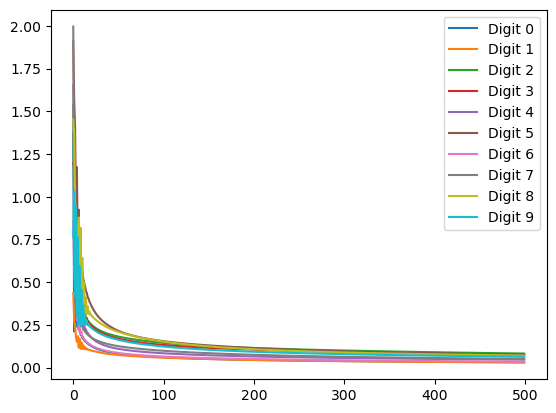

74.04058599472046

In [18]:
start_fit = time.time()
logistic_regression.fit(X_train, y_train, visualize=True)
time.time() - start_fit

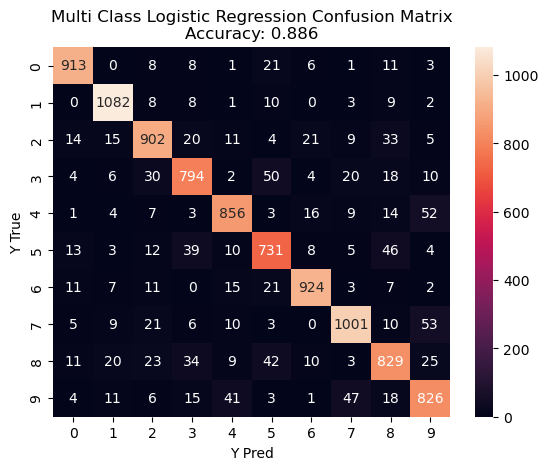

In [19]:
visualize_metrics(True, X_test, y_test, logistic_regression, 'Logistic Regression', binary_softmax)

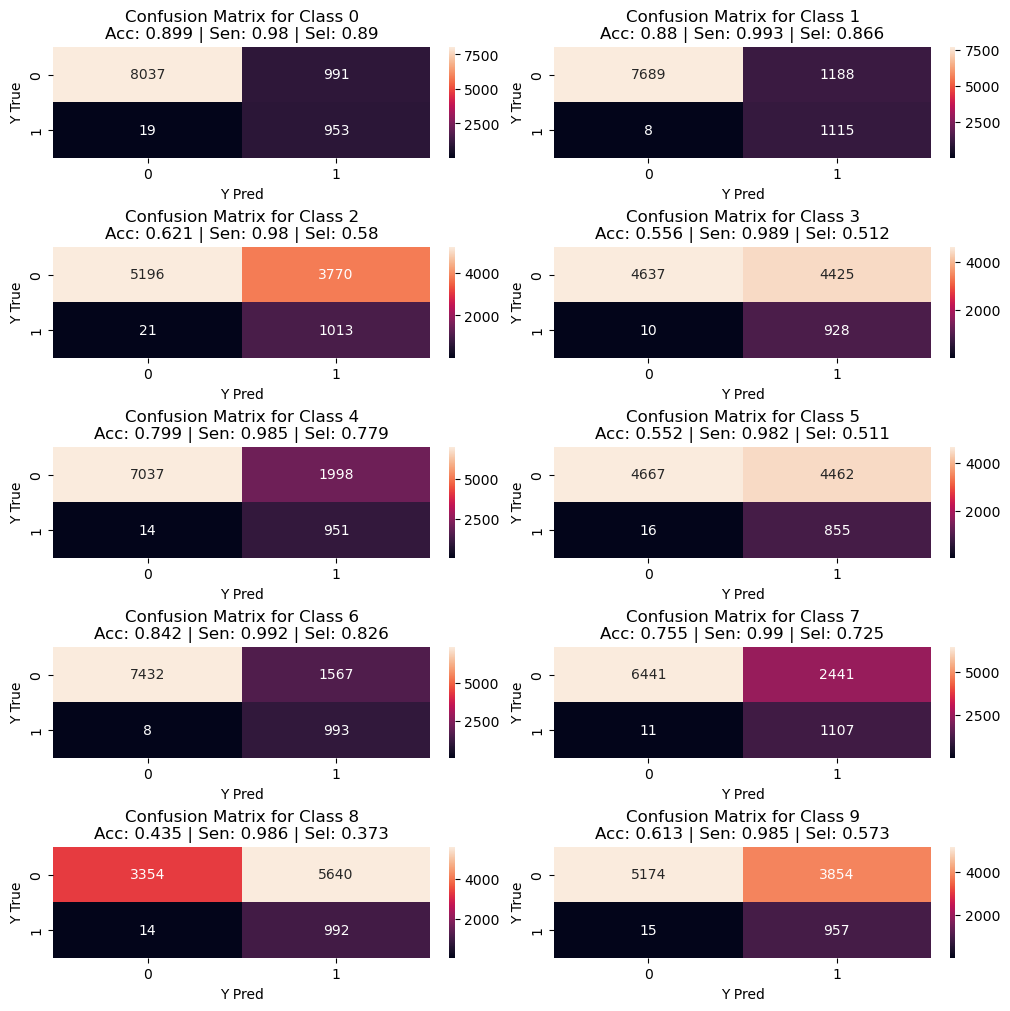

In [20]:
visualize_metrics(False, X_test, y_test, logistic_regression, 'Logistic Regression', binary_softmax)

In [21]:
'''
One thing to note, after making the metric function more generic, I decided that the confusion matrix for the binary classifiers will
be inverted from the previous maman, which means the True Positives will be in the bottom right corner and the True Negatives on the top
left corner, and the other 2 changed accordingly.

We can see from the results that the model is indeed pretty accurate but not as much confident in its' binary
classifiers as the perceptron is. Even more so, some of the binary classifiers' results are bad.
But, the sensitivity is almost perfect in most of the binary classifiers and the selectivity however is not so very high (some are
getting around 85% and the lower ones are getting 50-60% at most).
This leads us to the conclusion that there's a big ratio between the true negatives and the false positives, so
some of our binary classifiers are getting hard time in predicting negatives.
Ultimately, the model is being used as a multi class model, which his results are pretty assuring, even with its'
binary classifiers aren't very so.
Even though the training time is longer than the perceptron from maman 11, the results are very similar as a multi
class models, but very different binary-classifiers-wise, where the logistic regression's ones are worst.
The most notable errors are with the 2,3,5 and 8 digits, where the model sometimes mixes things up between the digits,
and from my understanding, its' the same case as with the perceptron, where the digits are written very similarily,
and the dominant pixels in all of them are very similar.

After a lot of trial and error and some grid search cross validation of the learning rate, number of epochs, weights values (non negative
and [-1,1] range values), I took a pretty high learning rate with 0.5 and a large value of epochs with 500.
That's after tried standarizing the features' values to a range of [0,1] after dividing by 255, and it required a larger number of epochs.
So I decided to normalize the values, after standarizing, to their respective Z values and it showed a better result with half the epochs
number.
It changed the binary classifiers' results quiet a bit. The accuracy in most of them was very low (not more than 50%)
but it did affect to model's performances slightly, with decreasing its' accuracy by 2-3%.
'''

"\nWe can see from the results that the model is indeed pretty accurate but not as much confident in its' binary\nclassifiers as the perceptron is. Even more so, the binary classifiers' results are bad.\nBut, the sensitivity is almost perfect in most of the binary classifiers and the selectivity however is very low (except\nfor digit 1).\nThis leads us to the conclusion that there's a big ratio between the true negatives and the false positives, so\nour binary classifiers are getting hard time in predicting negatives.\nUltimately, the model is being used as a multi class model, which his results are pretty assuring, even with its'\nbinary classifiers aren't very so.\nEven though the training time is longer than the perceptron from maman 11, the results are very similar as a multi\nclass models, but very different binary-classifiers-wise, where the logistic regression's ones are worst.\nThe most notable errors are with the 3,5 and 8 digits, where the model sometimes mixes things up betw

In [22]:
# used for matrix operations
from numpy import linalg as LA

class LinearRegression(BaseRegressor):

    def __init__(self, num_features, classes):
        # non_negative_weights aren't relevant here as our weights are "pre-defined" by the training data
        super().__init__(num_features, classes, non_negative_weights=True)

    def fit(self, X_train, y_train, visualize=True):
        super().init_multi_class_labels(y_train=y_train, negative_value=0)
        
        # getting the rank of the training data matrix
        is_X_train_full_rank = LA.matrix_rank(X_train) == min(X_train.shape[0], X_train.shape[1])
        # if the matrix is full rank we know the solution from the normal equations
        # and X @ X.T is invertible so we can get its' inverse
        if is_X_train_full_rank:
            self.weights = (self.labels @ X_train) @ LA.inv(X_train.T @ X_train)
            return
        
        # if it's not full rank, X.T @ X is not an invertible matrix so the weight vector we're looking for is 
        # A @ (X.T @ y) where A = V @ D+ @ V.T where V @ D @ V.T is the spectral decomposition of X.T @ X and D+ is 1/D 
        # for every [i,i]-th element that's different from 0 and 0 otherwise.
        # (unnecessary if using the pseudo inverse instead?)
        
        # V is the matrix which its' columns are the eigen vectors of X.T @ X
        # we can use the eigh function as X.T @ X is a symmetric matrix so all of its' eigenvalues are real
        eigen_values, V = LA.eigh(X_train.T @ X_train)
        # setting the eigen values in a diagonal matrix
        D = np.diag(eigen_values)
        # preparing the D+ matrix
        D_plus = D
        # setting the inverse of every non-zero eigen value
        D_plus[D_plus != 0] = 1 / D_plus[D_plus != 0]
        # according to page 125 in "Understanding Machine Learning: From Theory to Algorithms" book,
        # our weight vectors should be V @ D+ @ V.T @ X.T @ y, where our y here is self.labels
        self.weights = (self.labels @ X_train) @ V @ D_plus @ V.T

    def predict(self, X_test):
        return np.argmax(X_test @ self.weights.T, axis=1)
            

In [23]:
linear_regression = LinearRegression(X.shape[1], np.unique(y))

In [24]:
%%time
linear_regression.fit(X_train, y_train)

CPU times: user 11.3 s, sys: 382 ms, total: 11.7 s
Wall time: 1.99 s


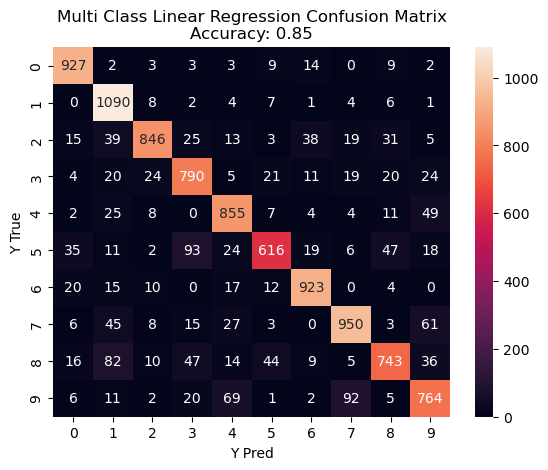

In [25]:
visualize_metrics(True, X_test, y_test, linear_regression, 'Linear Regression', np.sign)

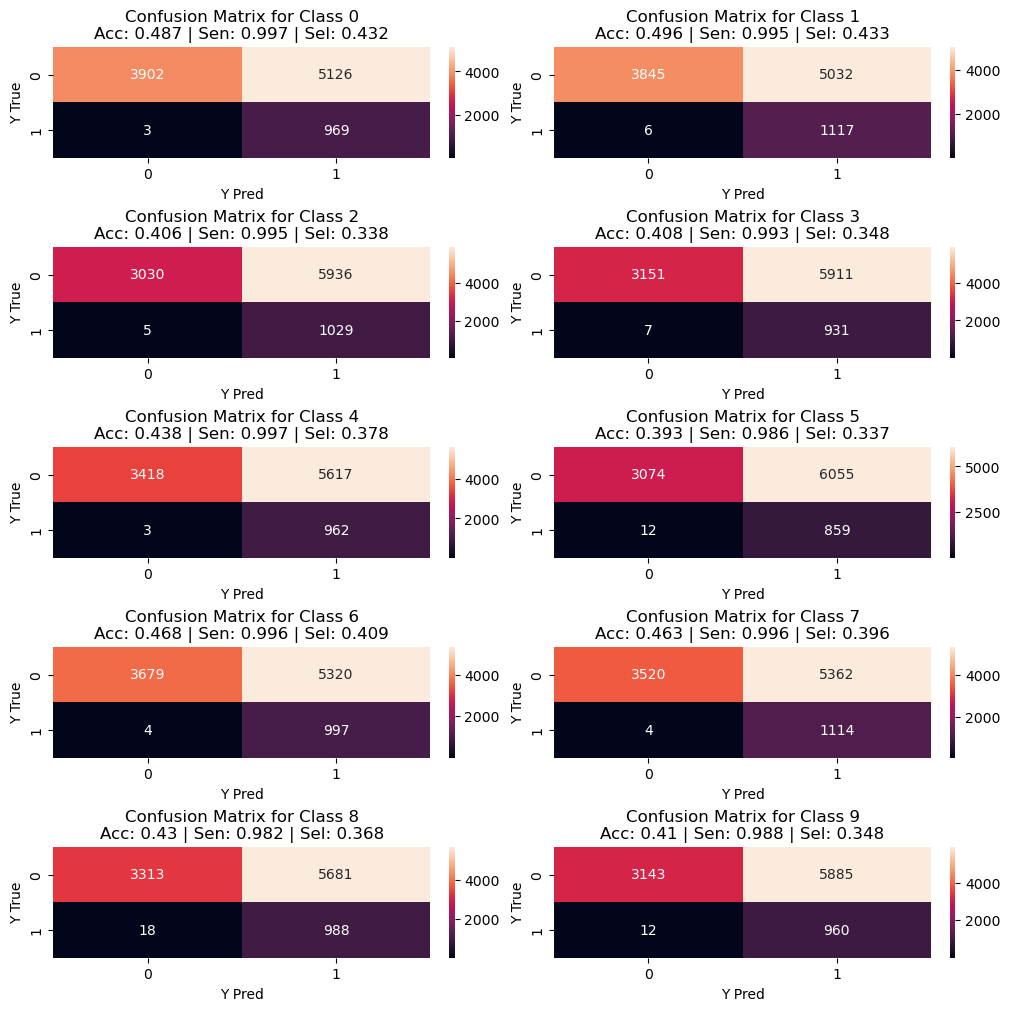

In [26]:
visualize_metrics(False, X_test, y_test, linear_regression, 'Linear Regression', np.sign)

In [27]:
'''
The linear regression model has a very different training process from the perceptron and the logistic regression models.
From class with Shai and from the "Understanding Machine Learning: From Theory to Algorithms" book, the solution can
be determined by the data straight away as the MSE loss function is simpler in terms of gradient calculations and 
as for finding the stationary vectors. Unlike the softmax function which requires gradient descent.
I took the more direct approach for dividing the training process into 2 possibilities:
The first is whether the training matrix is full rank. If it does, from class we can calculate straight away the best
weights from the normal equations.
The second is when the training matrix is not full rank. I wanted to use the eigenvalues and eigenvectors to better
understand how they are affecting the solution and for calculating the diagonal matrix which is part of the spectral
decomposition of X @ X.T. This solution is more straight forward in my opinion, as it's more informative and makes
the learning process ideal, both in terms of writing code and implementing the theory into action.

As for the results themselves, the linear regression is limited with its' performances based on the data itself.
Even though the model is mainly used for regression problems, i.e, predicting continuous values, it can be used for
classification but not as good as the logistic regression model. This is because of the loss function as it's indicating
how much the predicted values were "close" to the real values, which is not a recommended use case in classification
problems.
We could've gone with the gradient descent approach, which is much more time consuming and less elegant.
So ultimately, using linear regression for the dataset can be very fast and easy to implement, whereas using logistic
regression or the pocket perceptron models are getting more accurate results with slower training time.
'''

'\nThe linear regression model has a very different training process from the perceptron and the logistic regression models.\nFrom class with Shai and from the "Understanding Machine Learning: From Theory to Algorithms" book, the solution can\nbe determined by the data straight away as the MSE loss function is simpler in terms of gradient calculations and \nas for finding the stationary vectors. Unlike the softmax function which requires gradient descent.\nI took the more direct approach for dividing the training process into 2 possibilities:\nThe first is whether the training matrix is full rank. If it does, from class we can calculate straight away the best\nweights from the normal equations.\nThe second is when the training matrix is not full rank. I wanted to use the eigenvalues and eigenvectors to better\nunderstand how they are affecting the solution and for calculating the diagonal matrix which is part of the spectral\ndecomposition of X @ X.T. This solution is more straight for

In [28]:
time.time() - start_notebook_time

83.90257000923157